# GBDT+LR系列（组合高阶特征）

**模型示意图：**  
通过GBDT生成的特征，可直接作为LR的特征使用，省去人工处理分析特征的环节，LR的输入特征完全依赖于通过GBDT得到的特征通过GBDT生成的特征，可直接作为LR的特征使用，省去人工处理分析特征的环节，LR的输入特征完全依赖于通过GBDT得到的特征。  
![](./imgs/model.png)  
**思考：**　　

1）为什么要使用集成的决策树模型，而不是单棵的决策树模型：一棵树的表达能力很弱，不足以表达多个有区分性的特征组合，多棵树的表达能力更强一些，可以更好的发现有效的特征和特征组合。  
2）为什么建树采用GBDT而非RF：RF也是多棵树，但从效果上有实践证明不如GBDT。且GBDT前面的树，特征分裂主要体现对多数样本有区分度的特征；后面的树，主要体现的是经过前N颗树，残差仍然较大的少数样本。优先选用在整体上有区分度的特征，再选用针对少数样本有区分度的特征，思路更加合理，这应该也是用GBDT的原因。

## GBDT+LR（原始模型）

In [1]:
import numpy as np
np.random.seed(10)
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline

from matplotlib import rcParams

config = {
    "font.family":'Times New Roman',  # 设置字体类型
}
rcParams.update(config)

In [2]:
n_estimator = 10
X, y = make_classification(n_samples=80000)
X_train, X_test, y_train, y_test = train_test_split(X, y
                                                    , test_size = 0.2
                                                   )

X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train, y_train
                                                            , test_size=0.2
                                                           )

In [3]:
# 初始化模型
grd = GradientBoostingClassifier(n_estimators=n_estimator)
grd_enc = OneHotEncoder()
grd_lm = LogisticRegression(max_iter=1000)

In [4]:
grd.fit(X_train, y_train)  #GBDT建模
grd_enc.fit(grd.apply(X_train)[:, :, 0])  #编码OneHot向量[[1, 5, 6, 22......], [4, 5, 6, 2......]]
grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)

LogisticRegression(max_iter=1000)

In [5]:
grd_lm.predict(grd_enc.transform(grd.apply(X_test)[:, :, 0]))

array([0, 1, 1, ..., 0, 1, 0])

In [6]:
grd_lm.score(grd_enc.transform(grd.apply(X_test)[:, :, 0]), y_test)

0.957125

In [7]:
grd.apply(X_train)[:, :, 0]

array([[10., 10., 10., ..., 11., 10.,  6.],
       [10., 10., 10., ..., 10., 10.,  3.],
       [10., 10., 10., ..., 10., 10.,  4.],
       ...,
       [10., 10., 10., ..., 10., 10.,  3.],
       [ 6.,  6.,  6., ...,  6.,  6., 11.],
       [10., 10., 10., ..., 11., 10.,  6.]])

## RandomForest+LR（变体）

In [8]:
rf = RandomForestClassifier(max_depth=3, n_estimators=n_estimator)
rf_enc = OneHotEncoder()
rf_lm = LogisticRegression(max_iter=1000)

In [9]:
# 训练 model
rf.fit(X_train, y_train)
rf_enc.fit(rf.apply(X_train))
rf_lm.fit(rf_enc.transform(rf.apply(X_train_lr)), y_train_lr)

LogisticRegression(max_iter=1000)

In [10]:
# 每一维特征的类别
rf_enc.categories_

[array([ 3,  4,  6,  7, 10, 11, 13, 14]),
 array([ 3,  4,  6,  7, 10, 11, 13, 14]),
 array([ 3,  4,  6,  7, 10, 11, 13, 14]),
 array([ 3,  4,  6,  7, 10, 11, 13, 14]),
 array([ 3,  4,  6,  7, 10, 11, 13, 14]),
 array([ 3,  4,  6,  7, 10, 11, 13, 14]),
 array([ 3,  4,  6,  7, 10, 11, 13, 14]),
 array([3, 4, 6, 7, 8]),
 array([ 3,  4,  6,  7, 10, 11, 13, 14]),
 array([ 3,  4,  6,  7, 10, 11, 13, 14])]

In [11]:
rf_enc.get_feature_names()

array(['x0_3', 'x0_4', 'x0_6', 'x0_7', 'x0_10', 'x0_11', 'x0_13', 'x0_14',
       'x1_3', 'x1_4', 'x1_6', 'x1_7', 'x1_10', 'x1_11', 'x1_13', 'x1_14',
       'x2_3', 'x2_4', 'x2_6', 'x2_7', 'x2_10', 'x2_11', 'x2_13', 'x2_14',
       'x3_3', 'x3_4', 'x3_6', 'x3_7', 'x3_10', 'x3_11', 'x3_13', 'x3_14',
       'x4_3', 'x4_4', 'x4_6', 'x4_7', 'x4_10', 'x4_11', 'x4_13', 'x4_14',
       'x5_3', 'x5_4', 'x5_6', 'x5_7', 'x5_10', 'x5_11', 'x5_13', 'x5_14',
       'x6_3', 'x6_4', 'x6_6', 'x6_7', 'x6_10', 'x6_11', 'x6_13', 'x6_14',
       'x7_3', 'x7_4', 'x7_6', 'x7_7', 'x7_8', 'x8_3', 'x8_4', 'x8_6',
       'x8_7', 'x8_10', 'x8_11', 'x8_13', 'x8_14', 'x9_3', 'x9_4', 'x9_6',
       'x9_7', 'x9_10', 'x9_11', 'x9_13', 'x9_14'], dtype=object)

In [12]:
# 获得样本在每一颗子树上叶子结点的索引位置
rf.apply(X_train).shape

(51200, 10)

In [13]:
# 每棵子树的叶子结点的个数
[ tree.get_n_leaves() for tree in rf.estimators_ ]

[8, 8, 8, 8, 8, 8, 8, 5, 8, 8]

In [14]:
set(rf.apply(X_train_lr)[:, 0])

{3, 4, 6, 7, 10, 11, 13, 14}

In [15]:
# 编码RF输出为OneHot向量
rf_enc.transform(rf.apply(X_train_lr)).toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## ROC曲线比较

In [16]:
# GBDT+LR
y_pred_grd_lm = grd_lm.predict_proba(grd_enc.transform(grd.apply(X_test)[:, :, 0]))[:, 1]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred_grd_lm)

# GBDT
y_pred_grd = grd.predict_proba(X_test)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)

# RF
y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

# RF+LR
y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(X_test)))
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_pred_rf_lm[:, 1])

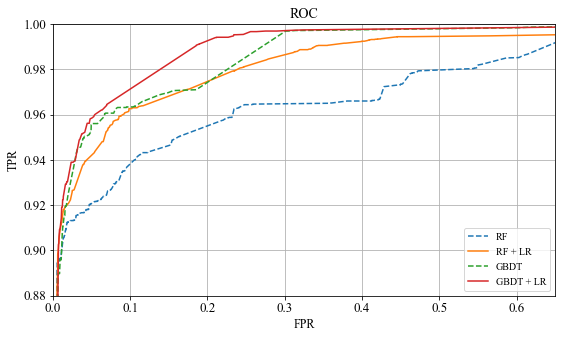

In [32]:
plt.figure(figsize=(9, 5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF', linestyle="--")
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBDT', linestyle="--")
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBDT + LR')
plt.xlabel('FPR', fontsize=12)
plt.ylabel('TPR', fontsize=12)
plt.title('ROC', fontsize=14)
plt.tick_params(labelsize=13)  # 设置刻度字体大小
plt.grid()
plt.xlim(0, 0.65)
plt.ylim(0.88, 1)
plt.legend(loc=4)
plt.savefig("./imgs/roc.png")
plt.show()

## 参考
[腾讯大数据：CTR预估中GBDT与LR融合方案](https://cloud.tencent.com/developer/article/1030026)  
[原创 | 万字长文，剖析经典论文GBDT+LR](https://cloud.tencent.com/developer/article/1731512)